# Comparison of losses

For a binary classification task we compare cross entropy loss to square error loss.

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.utils import shuffle
import numpy as np
import time
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

2023-11-29 09:59:03.203335: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We load the fashion-MNIST dataset, a dataset of the same form and format as MNIST, only instead of handwritten digits it shows different types of clothing. The aim consists in identifying the type of clothing (shoe, T-shirt etc). See https://github.com/zalandoresearch/fashion-mnist

Because we will repeat the experiment several times, each time with a new random training and test set, we first merge the training and test set returned by <code>load_data</code>.

In [2]:
fashion = tf.keras.datasets.fashion_mnist
(x1, y1), (x2, y2) = fashion.load_data()
X=np.vstack([x1,x2])
y=np.hstack([y1,y2])
X=X/255. # normalise so that all values in [0,1]

For a simpler example let's restrict the dataset to two classes, jumpers (class 2) and T-shirts (class 0)

In [3]:
X_bin=X[(y==0) | (y==2)]
y_bin=y[(y==0) | (y==2)]/2 # divide by 2, in order to get classes 0,1

Next, let's write a method that returns a random training and test set. 

In [4]:
train_size=7000
def get_datasets():
    XX,yy=shuffle(X_bin,y_bin)
    x_bin_train,x_bin_test=XX[:train_size],XX[train_size:]
    y_bin_train,y_bin_test=yy[:train_size],yy[train_size:]
    return x_bin_train,y_bin_train,x_bin_test,y_bin_test

We choose a simple neural network with two hidden layers, and a single output neuron with logistic activation

In [5]:
def get_model():
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(80, activation='relu'),
      tf.keras.layers.Dense(40, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

To keep track of the gradient norms we define a <code>Callback</code> class. It is called before each epoch starts and then tries to estimate the gradient norms. It would certainly be better to keep track of the gradients that are actually used for training. I didn't, however, want to write my own training method, which then would be necessary. Instead, we simply calculate the gradient with respect to 1000 samples from the training set. 

In [6]:
class Grad_Tracker(keras.callbacks.Callback):
    def __init__(self,model,loss_fn,x_val,y_val):
        self.grad_norms=[]
        self.grad_stds=[]
        self.model=model
        self.loss_fn=loss_fn
        self.x_val=x_val
        self.y_val=y_val.reshape(-1,1)
        self.grad_size=[]
        
    def on_epoch_begin(self,epoch,logs=None):
        grad_norms=[]
        with tf.GradientTape() as tape:
            y_pred=self.model(self.x_val,training=True)
            loss = self.loss_fn(self.y_val,y_pred)
        grads = tape.gradient(loss, self.model.trainable_weights)
        norms=[tf.math.sqrt(tf.reduce_sum(g**2)) for g in grads if tf.rank(g).numpy()>1] # exclude biases
        stds=[tf.math.reduce_std(g) for g in grads if tf.rank(g).numpy()>1] # exclude biases
        self.grad_size.append([tf.size(g) for g in grads if tf.rank(g).numpy()>1]) # exclude biases
        self.grad_norms.append(norms)
        self.grad_stds.append(stds)

Now let's do the experiment. For both loss functions, cross entropy and square loss, I previously determined that a learning rate of 0.05 seems to work fine. We train a neural network with each of the loss functions for 40 epochs and record the result. Then we repeat that process 20 times, so that we get a bit of statistical stability. The code looks a bit difficult because I want to have some feedback of what's happening.

In [7]:
REPEATS=20
EPOCHS=40
num_grads=1000

def run_model(learning_rate,loss,name):
    print(" -> {} fit ".format(name),end="")    
    model=get_model()
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),loss=loss, metrics=['accuracy'])
    x_grad,y_grad=x_bin_train[:num_grads],y_bin_train[:num_grads]
    grad_tracker=Grad_Tracker(model,loss,x_grad,y_grad)
    history=model.fit(x_bin_train, y_bin_train, epochs=EPOCHS,validation_data=(x_bin_test,y_bin_test),verbose=0,callbacks=[grad_tracker])
    print("- {:.1f}s".format(time.time()-start),end="")
    return history,grad_tracker

loss_X = tf.keras.losses.BinaryCrossentropy()
loss_mse = tf.keras.losses.MeanSquaredError()
histories_X=[]
histories_mse=[]
grad_trackers_X=[]
grad_trackers_mse=[]
start=time.time()
for i in range(REPEATS):
    print("** iteration {} **".format(i+1),end="")
    x_bin_train,y_bin_train,x_bin_test,y_bin_test=get_datasets()
    history,grad_tracker=run_model(0.05,loss_X,"cross entropy")
    histories_X.append(history)
    grad_trackers_X.append(grad_tracker)
    history,grad_tracker=run_model(0.05,loss_mse,"square loss")
    histories_mse.append(history)
    grad_trackers_mse.append(grad_tracker)
    print("")

** iteration 1 ** -> cross entropy fit 

2023-11-29 09:59:16.249654: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 09:59:16.250952: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


- 66.4s -> square loss fit - 127.9s
** iteration 2 ** -> cross entropy fit - 210.3s -> square loss fit - 263.8s
** iteration 3 ** -> cross entropy fit - 323.9s -> square loss fit - 383.0s
** iteration 4 ** -> cross entropy fit - 442.2s -> square loss fit - 501.7s
** iteration 5 ** -> cross entropy fit - 569.6s -> square loss fit - 632.8s
** iteration 6 ** -> cross entropy fit - 693.6s -> square loss fit - 744.4s
** iteration 7 ** -> cross entropy fit - 791.0s -> square loss fit - 873.4s
** iteration 8 ** -> cross entropy fit - 918.0s -> square loss fit - 970.3s
** iteration 9 ** -> cross entropy fit - 1029.9s -> square loss fit - 1086.4s
** iteration 10 ** -> cross entropy fit - 1142.4s -> square loss fit - 1196.9s
** iteration 11 ** -> cross entropy fit - 1254.1s -> square loss fit - 1321.9s
** iteration 12 ** -> cross entropy fit - 1379.9s -> square loss fit - 1442.5s
** iteration 13 ** -> cross entropy fit - 1497.2s -> square loss fit - 1579.6s
** iteration 14 ** -> cross entropy fi

When you spend a lot of time computing some data, it's always a good idea to save the results, so that you don't need to re-run the whole computation because you later find that you'd like to change the colour of the plot. We also repackage the data into a dictionary because a dictionary is easier to reconstruct when loading the data from the hard drive.

In [8]:
def save_data(loss_type,name,histories):
    losses=[history.history[loss_type] for history in histories]
    epochs=len(losses[0])
    filename="XX{}_{}.dat".format(loss_type,name)
    header="notebook loss_compare.ipynb\neach row, one run with {} epochs\nloss function: {} ** reported metric: {}".format(epochs,name,loss_type)
    np.savetxt(filename,losses,header=header)
    return losses

def save_grad_data(grad_trackers,name):
    grad_norms=np.array([grad_tracker.grad_norms for grad_tracker in grad_trackers])
    filename="XXgrads_{}.dat".format(name)
    #header="notebook loss_compare.ipynb\nformat: repeats x epochs x layers"
    np.save(filename,grad_norms)
    return grad_norms

def convert_and_save():
    results={}
    results["loss_cross_entropy"]=save_data("loss","cross_entropy",histories_X)
    results["loss_mse"]=save_data("loss","square_loss",histories_mse)
    results["acc_cross_entropy"]=save_data("accuracy","cross_entropy",histories_X)
    results["acc_mse"]=save_data("accuracy","square_loss",histories_mse)
    results["val_acc_cross_entropy"]=save_data("val_accuracy","cross_entropy",histories_X)
    results["val_acc_mse"]=save_data("val_accuracy","square_loss",histories_mse)
    results["grad_norms_cross_entropy"]=save_grad_data(grad_trackers_X,"cross_entropy")
    results["grad_norms_mse"]=save_grad_data(grad_trackers_mse,"square_loss")
    return results

def load_data(loss_type,name):
    return np.loadtxt("XX{}_{}.dat".format(loss_type,name))

def load_grad_data(name):
    filename="XXgrads_{}.dat".format(name)
    return np.load(filename)

def load_all_data():
    results={}
    results["loss_cross_entropy"]=load_data("loss","cross_entropy")
    results["loss_mse"]=load_data("loss","square_loss")
    results["acc_cross_entropy"]=load_data("accuracy","cross_entropy")
    results["acc_mse"]=load_data("accuracy","square_loss")
    results["val_acc_cross_entropy"]=load_data("val_accuracy","cross_entropy")
    results["val_acc_mse"]=load_data("val_accuracy","square_loss")
    results["grad_norms_cross_entropy"]=load_grad_data("grads","cross_entropy")
    results["grad_norms_mse"]=load_grad_data("grads","square_loss")
    return result
        
results=convert_and_save()
#results=load_all_data()


Let's plot. For the gradients, we concentrate on the middle layer: It's not as small as the output layer, and we should still see the dampening effect of the square loss. (In fact, all gradients look extremely similar.)

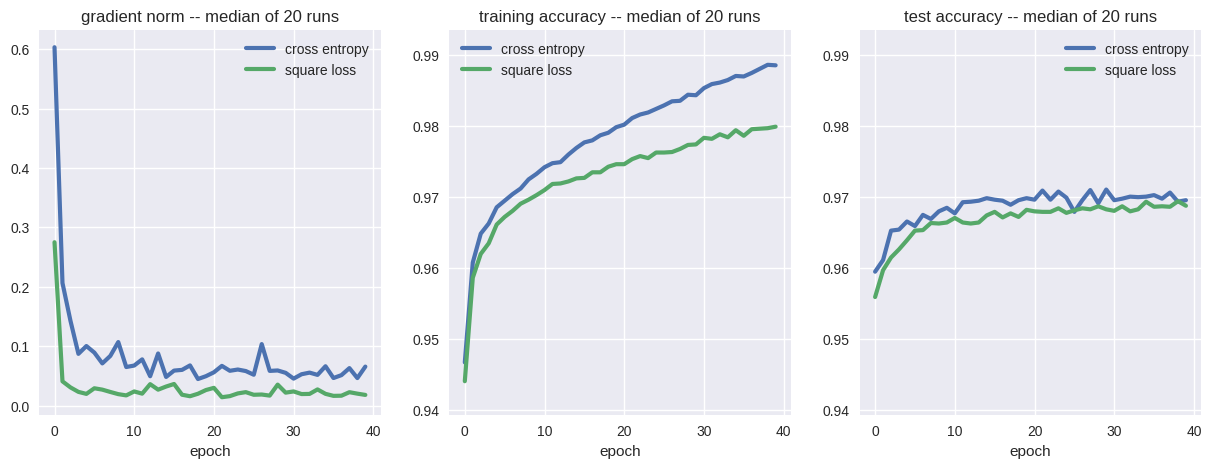

In [24]:
def plot_grads(layer,ax):
    grad_norms=np.median(results["grad_norms_cross_entropy"][:,:,layer],axis=0)
    epochs=results["grad_norms_cross_entropy"].shape[1]
    ax.plot(grad_norms,label="cross entropy",linewidth=3)
    grad_norms=np.median(results["grad_norms_mse"][:,:,layer],axis=0)
    ax.plot(grad_norms,label="square loss",linewidth=3)    


epochs=len(results["acc_cross_entropy"])

acc_X=np.median(results["acc_cross_entropy"],axis=0)
acc_mse=np.median(results["acc_mse"],axis=0)
ymin=min(min(acc_X),min(acc_mse))*0.995
ymax=max(max(acc_X),max(acc_mse))*1.005

fig,axs=plt.subplots(1,3,figsize=(15,5))
axs=axs.flat

ax=axs[0]
layer=1
plot_grads(layer,ax)
ax.set_xlabel("epoch")
ax.set_title("gradient norm -- median of {} runs".format(epochs))
ax.legend()

ax=axs[1]
ax.plot(acc_X,label="cross entropy",linewidth=3)
ax.plot(acc_mse,label="square loss",linewidth=3)
ax.set_title("training accuracy -- median of {} runs".format(epochs))
ax.set_xlabel("epoch")
ax.set_ylim(ymin,ymax)
ax.legend()

ax=axs[2]
ax.plot(np.median(results["val_acc_cross_entropy"],axis=0),label="cross entropy",linewidth=3)
ax.plot(np.median(results["val_acc_mse"],axis=0),label="square loss",linewidth=3)
ax.set_title("test accuracy -- median of {} runs".format(epochs))
ax.set_xlabel("epoch")
ax.set_ylim(ymin,ymax)
ax.legend()


Yes, the square loss gradients are smaller. Training accuracy for square loss is increasing more slowly. Test accuracy, however, is comparable. This may be because the neural network has basically reached its capacity. Why, though, are small gradients a problem at all? We could perhaps compensate by increasing the learning rate. So, let's double the learning rate for square loss and try again. The results will not be entirely comparable to the earlier results as we draw the training sets again. Still, since we repeat every setup 20 times, I'd argue that we can still draw insights from the results.

In [16]:
histories_mse2=[]
grad_trackers_mse2=[]
start=time.time()
for i in range(REPEATS):
    print("** iteration {} **".format(i+1),end="")
    x_bin_train,y_bin_train,x_bin_test,y_bin_test=get_datasets()
    history,grad_tracker=run_model(0.05*2,loss_mse,"square loss")
    histories_mse2.append(history)
    grad_trackers_mse2.append(grad_tracker)
    print("")

** iteration 1 ** -> square loss fit - 67.8s
** iteration 2 ** -> square loss fit - 150.4s
** iteration 3 ** -> square loss fit - 215.2s
** iteration 4 ** -> square loss fit - 284.0s
** iteration 5 ** -> square loss fit - 342.9s
** iteration 6 ** -> square loss fit - 408.7s
** iteration 7 ** -> square loss fit - 491.2s
** iteration 8 ** -> square loss fit - 557.1s
** iteration 9 ** -> square loss fit - 616.3s
** iteration 10 ** -> square loss fit - 699.0s
** iteration 11 ** -> square loss fit - 768.4s
** iteration 12 ** -> square loss fit - 828.6s
** iteration 13 ** -> square loss fit - 885.7s
** iteration 14 ** -> square loss fit - 951.0s
** iteration 15 ** -> square loss fit - 1010.1s
** iteration 16 ** -> square loss fit - 1075.5s
** iteration 17 ** -> square loss fit - 1139.5s
** iteration 18 ** -> square loss fit - 1196.0s
** iteration 19 ** -> square loss fit - 1260.6s
** iteration 20 ** -> square loss fit - 1320.5s


To plot the results, we do a bit of code repitition. My apologies. 

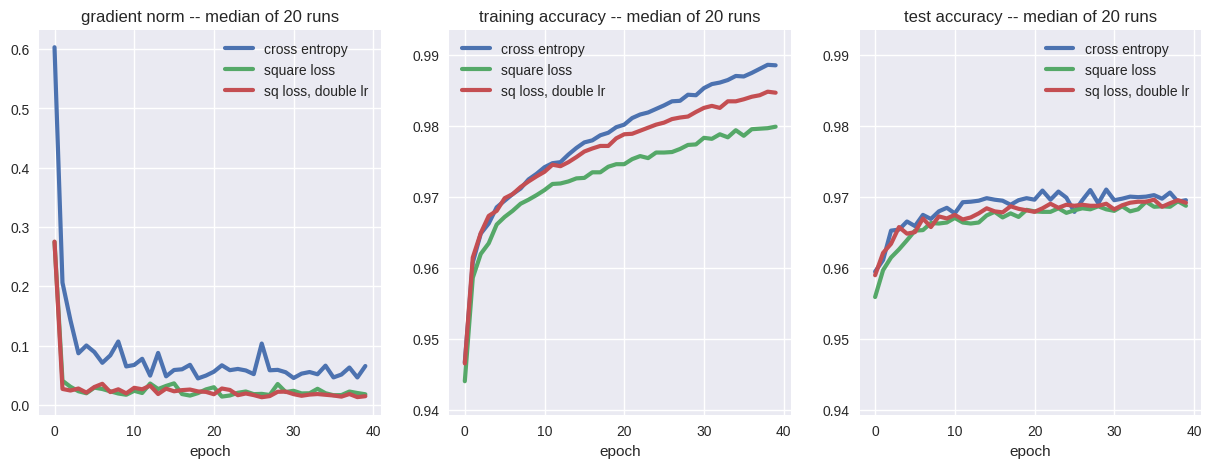

In [25]:
fig,axs=plt.subplots(1,3,figsize=(15,5))
axs=axs.flat

ax=axs[0]
plot_grads(layer,ax)
grad_norms_mse2=np.array([grad_tracker.grad_norms for grad_tracker in grad_trackers_mse2])
grad_norms=np.median(grad_norms_mse2[:,:,layer],axis=0)
ax.plot(grad_norms,label="sq loss, double lr",linewidth=3)
ax.set_xlabel("epoch")
ax.set_title("gradient norm -- median of {} runs".format(epochs))
ax.legend()

ax=axs[1]
losses=np.median([history.history["accuracy"] for history in histories_mse2],axis=0)
ax.plot(acc_X,label="cross entropy",linewidth=3)
ax.plot(acc_mse,label="square loss",linewidth=3)
ax.plot(losses,label="sq loss, double lr",linewidth=3)
ax.set_title("training accuracy -- median of {} runs".format(epochs))
ax.set_xlabel("epoch")
ax.set_ylim(ymin,ymax)
ax.legend()

ax=axs[2]
losses=np.median([history.history["val_accuracy"] for history in histories_mse2],axis=0)
ax.plot(np.median(results["val_acc_cross_entropy"],axis=0),label="cross entropy",linewidth=3)
ax.plot(np.median(results["val_acc_mse"],axis=0),label="square loss",linewidth=3)
ax.plot(losses,label="sq loss, double lr",linewidth=3)
ax.set_title("test accuracy -- median of {} runs".format(epochs))
ax.set_xlabel("epoch")
ax.set_ylim(ymin,ymax)
ax.legend()


What do we see? First, the gradient norms for square loss with learning rate 0.05 and learning rate 0.1 are virtually identical. Second, increased learning rate indeed increases training accuracy. That is, it really seems we can compensate for the smaller gradients by bumping up the learning rate. All in all, we do not really see the effect claimed in the literature: that square loss coupled with a logistic output layer leads to slower learning. 

Why is that? Perhaps the classification task was too easy? Perhaps I did not finetune the learning rates correctly? That is, perhaps the cross entropy setup could also benefit from a higher learning rate? 